In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from tqdm.auto import tqdm
from rl_analysis.plotting import (
    setup_plotting_env,
    geno_palette,
    clean_ticks,
    savefig
)
from rl_analysis.photometry.signal import get_crossings, get_ncrossings
from rl_analysis.io.df import dlight_exclude_toml
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import itertools
import os
import seaborn as sns
import joblib

In [3]:
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests

In [4]:
threshold = 0
schmitt = 3
schmitt_threshold = 0.25 * threshold

In [5]:
import toml

with open("../analysis_configuration.toml", "r") as f:
    analysis_config = toml.load(f)

In [6]:
raw_dirs = analysis_config["raw_data"]
proc_dirs = analysis_config["intermediate_results"]
lagged_cfg = analysis_config["dlight_lagged_correlations"]
dlight_cfg = analysis_config["dlight_common"]
figure_cfg = analysis_config["figures"]

In [7]:
use_dct = dlight_exclude_toml(
    os.path.join(raw_dirs["dlight"], "dlight_photometry_processed_full.toml"),
    **dlight_cfg
)

In [8]:
df_filtered = pd.read_parquet(
    os.path.join(raw_dirs["dlight"], "dlight_photometry_processed_full.parquet"),
    filters=[("uuid", "in", list(use_dct.keys()))],
).sort_index()

In [9]:
df_filtered["area"] = df_filtered["area"].astype("str")
df_filtered["mouse_id"] = df_filtered["mouse_id"].astype("str")

# Basic stats

In [10]:
threshold = 1

In [11]:
def get_transient_rate(df):
    return get_ncrossings(
        df,
        threshold=threshold,
        schmitt=3,
        schmitt_threshold=0.25 * threshold,
    )

In [12]:
def get_transient_loc(df):
    return get_crossings(
        df.to_numpy(),
        threshold=threshold,
        schmitt=3,
        schmitt_threshold=0.25 * threshold,
    )

In [13]:
df_filtered["time_bin"] = pd.cut(
    df_filtered["timestamp"], np.arange(0, 1805, 300), labels=False
)

In [14]:
transient_rate = (
    df_filtered.set_index("timestamp")
    .groupby(["area", "mouse_id", "uuid", "time_bin"])["signal_reref_dff_z"]
    .agg(get_transient_rate)
    .rename("rate")
)

In [15]:
df_filtered["is_transient"] = (
    df_filtered.groupby(["area", "mouse_id", "uuid"])["signal_reref_dff_z"]
    .transform(get_transient_loc)
    .rename("crossings")
)

In [16]:
peak_locs = df_filtered.groupby(["area", "mouse_id", "uuid"])["is_transient"].apply(
    lambda x: np.flatnonzero(x > 0)
)

In [17]:
def get_windows(data, index, peak_locs=peak_locs, window=(90, 90)):
    grab_indices = peak_locs.loc[index]
    grab_indices = grab_indices[
        (grab_indices > window[0]) & (grab_indices < (len(data) - window[1]))
    ]
    vec_grab = grab_indices[:, None] + np.arange(-window[0], window[1])
    return data.values[vec_grab]

In [18]:
def add_time_axis(data, threshold=0.03, fs=30.0):
    # use turning point (i.e. where the curve starts to take off prior to the peak)
    slope = np.insert(data[2:] - data[:-2], 0, [np.nan] * 2)
    peak_loc = np.argmax(data)

    for i in range(peak_loc - 2, 0, -1):
        if slope[i] < threshold:
            break

    new_index = np.arange(-i, len(data) - i)
    return pd.Series(data=data, index=new_index / fs)

In [19]:
def get_fwhm(values, fs=30.0, interpolate_fs=500.0):
    from scipy import interpolate

    if interpolate_fs is not None:
        x = np.arange(len(values)) / fs
        y = values.to_numpy()
        f = interpolate.interp1d(x, y, kind="cubic")

        new_period = 1 / interpolate_fs
        nsteps = np.round(x[-1] / new_period).astype("int")
        newx = np.linspace(x[0], x[-1], nsteps)
        newy = f(newx)
        values = newy
        use_fs = interpolate_fs
    else:
        values = values.values
        use_fs = fs

    idxmax = np.argmax(values)
    maxval = values[idxmax]

    for i in range(idxmax, 0, -1):
        if values[i] <= 0.5 * maxval:
            break

    left_idx = i

    for i in range(idxmax, len(values)):
        if values[i] <= 0.5 * maxval:
            break

    right_idx = i
    return (right_idx - left_idx) / use_fs

In [20]:
tqdm.pandas()

In [21]:
peak_triggered_windows = df_filtered.groupby(["area", "mouse_id", "uuid"])[
    "signal_reref_dff_z"
].progress_apply(lambda x: get_windows(x, x.name))
peak_triggered_window_averages = peak_triggered_windows.apply(
    lambda x: np.nanmean(x, axis=0)
)
mouse_averages = (
    peak_triggered_window_averages.groupby(["area", "mouse_id"]).mean().dropna()
)

  0%|          | 0/442 [00:00<?, ?it/s]

/tmp/ipykernel_1554882/2853326471.py:5: RuntimeWarning: Mean of empty slice
  lambda x: np.nanmean(x, axis=0)


In [22]:
realigned_mouse_averages = (
    mouse_averages.apply(lambda x: add_time_axis(x, threshold=0.035))
    .melt(ignore_index=False, var_name="x")
    .set_index("x", append=True)
)

In [23]:
auc = (
    realigned_mouse_averages.loc[
        (realigned_mouse_averages.index.get_level_values("x") >= 0)
        & (realigned_mouse_averages.index.get_level_values("x") <= 2)
    ]
    .groupby(["area", "mouse_id"], observed=True)["value"]
    .apply(lambda x: np.trapz(x.to_numpy()))
    .rename("auc")
)

idxmax = (
    realigned_mouse_averages.loc[
        (realigned_mouse_averages.index.get_level_values("x") >= 0)
        & (realigned_mouse_averages.index.get_level_values("x") <= 2)
    ]
    .groupby(["area", "mouse_id"], observed=True)["value"]
    .apply(lambda x: x.index.get_level_values("x")[np.argmax(x)])
    .rename("time_to_peak")
)

fwhm = (
    realigned_mouse_averages.loc[
        (realigned_mouse_averages.index.get_level_values("x") >= 0)
        & (realigned_mouse_averages.index.get_level_values("x") <= 2)
    ]
    .groupby(["area", "mouse_id"], observed=True)["value"]
    .apply(get_fwhm)
    .rename("fwhm")
)

In [24]:
da_rate = transient_rate.dropna().groupby(["area", "mouse_id"], observed=True).median().rename("da_rate")
da_stats = pd.concat([auc, idxmax, fwhm, da_rate], axis=1)

In [25]:
ref = da_stats.loc["dls"].median()
fold_da_stats = 1e2 * ((da_stats - ref) / ref)
melt_stats = da_stats.melt(ignore_index=False)

In [26]:
setup_plotting_env()

In [27]:
aliases = {
    "auc": "Area under the curve",
    "time_to_peak": "Time to peak (s)",
    "fwhm": "Full-width\nhalf-max (s)",
    "da_rate": "Transient rate (Hz)",
}

In [29]:
fold_melt_stats = fold_da_stats.melt(ignore_index=False)

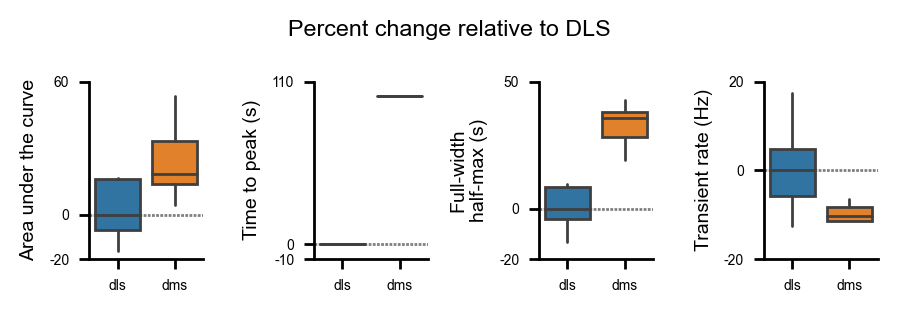

In [30]:
g = sns.catplot(
    data=fold_melt_stats.reset_index(),
    x="area",
    height=1.5,
    aspect=0.75,
    y="value",
    col="variable",
    kind="box",
    showfliers=False,
    showcaps=False,
    sharey=False,
)
g.set_titles(col_template="{col_name}")
g.set_axis_labels("", "")
for _ax in g.axes.ravel():
    _ax.set_ylabel(aliases.get(_ax.get_title()))
    _ax.set_title("")
    _ax.axhline(
        y=0,
        zorder=-300,
        color=plt.rcParams["axes.edgecolor"],
        alpha=0.5,
        ls="--",
        dashes=(1, 0.5),
    )

for _ax in g.axes.ravel():
    clean_ticks(_ax, "y", zero_symmetry=False, precision=-1, dtype=int)
g.fig.suptitle("Percent change relative to DLS")
g.fig.tight_layout()
savefig(
    g.fig,
    os.path.join(figure_cfg["store_dir"], "dls_vs_dms_basicfeatures_percent_change"),
)

In [31]:
fold_melt_stats.groupby(["area", "mouse_id", "variable"]).mean().loc["dms"]

value
mouse_id      variable                
dms-dlight-1  auc             4.219673
              da_rate        -3.178674
              fwhm           26.190476
              time_to_peak  100.000000
dms-dlight-10 auc            19.105121
              da_rate        -6.427995
              fwhm           28.571429
              time_to_peak  100.000000
dms-dlight-11 auc            53.563996
              da_rate       -11.477645
              fwhm           42.857143
              time_to_peak  100.000000
dms-dlight-13 auc            14.003626
              da_rate        -8.711340
              fwhm           19.047619
              time_to_peak  100.000000
dms-dlight-14 auc            32.465188
              da_rate       -16.680207
              fwhm           36.904762
              time_to_peak  100.000000
dms-dlight-4  auc            13.877608
              da_rate       -10.333597
              fwhm           34.523810
              time_to_peak  100.000000
dms-dlight-6  auc            17.472487
              da_rate       -11.310049
              fwhm           36.904762
              time_to_peak  100.000000
dms-dlight-8  auc            36.362527
              da_rate       -10.338552
              fwhm           41.666667
              time_to_peak  100.000000

In [32]:
feature_stats = {}

In [33]:
use_test = mannwhitneyu

In [34]:
sz = da_stats.groupby("area").size()
normalizer = sz.prod()

In [35]:
stats, p = use_test(da_stats.loc["dls"], da_stats.loc["dms"])

In [36]:
dcts = []

In [37]:
for feature_name, p, u, f in zip(da_stats.columns, p, stats, stats / normalizer):
    dct = {
        "p": p,
        "f": f,
        "u": u,
        "n1": sz.loc["dls"],
        "n2": sz.loc["dms"],
        "n_definition": "per-mouse average",
        "test": use_test.__name__,
        "feature_name": feature_name,
    }
    dcts.append(dct)

In [38]:
feature_pval_df = pd.DataFrame(dcts)

In [39]:
feature_pval_df["p"] = multipletests(feature_pval_df["p"], method="holm")[1]

In [40]:
feature_pval_df

,p,f,u,n1,n2,n_definition,test,feature_name
0,0.051752,0.241071,27.0,14,8,per-mouse average,mannwhitneyu,auc
1,0.000149,0.035714,4.0,14,8,per-mouse average,mannwhitneyu,time_to_peak
2,0.017118,0.142857,16.0,14,8,per-mouse average,mannwhitneyu,fwhm
3,0.017118,0.866071,97.0,14,8,per-mouse average,mannwhitneyu,da_rate


In [41]:
import json

In [42]:
with open(
    os.path.join(proc_dirs["dlight"], "dls_vs_dms_transient_features.toml"), "w"
) as f:
    toml.dump(json.loads(feature_pval_df.T.to_json()), f)

In [43]:
# run hypothesis tests and stash

/home/markowitzmeister_gmail_com/miniconda3/envs/spont-da/lib/python3.10/site-packages/seaborn/axisgrid.py:848: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 68)` for the same effect.

  func(*plot_args, **plot_kwargs)


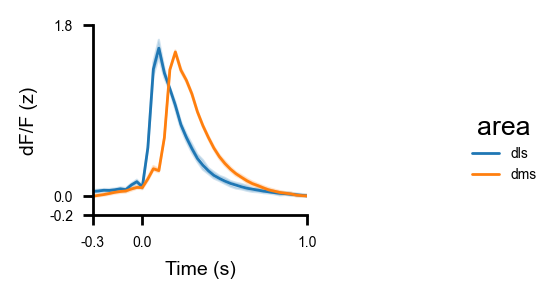

In [44]:
g = sns.relplot(
    data=realigned_mouse_averages.reset_index(),
    x="x",
    y="value",
    hue="area",
    ci=68,
    height=1,
    n_boot=100,
    kind="line",
)
g.fig.set_size_inches(4, 2)
g.set_axis_labels("Time (s)", "dF/F (z)")
plt.xlim(-0.25, 1)
clean_ticks(g.axes, "x", precision=1, zero_symmetry=False)
clean_ticks(g.axes, "y", precision=1, zero_symmetry=False)
savefig(g.fig, os.path.join(figure_cfg["store_dir"], "dls_vs_dms_transient_timecourse"))

# Average encoding model

In [45]:
r_df_ave = pd.read_parquet(
    os.path.join(proc_dirs["dlight"], "encoding_model_average_variant_results.parquet")
)

In [46]:
r_df_ave = r_df_ave.rename(columns={"variable": "type"})

In [47]:
mu_df = r_df_ave.groupby(["area", "type", "mouse_id"]).mean()

In [48]:
kwargs = {
    "data": mu_df.reset_index(),
    "x": "area",
    "y": "r",
    "hue": "type",
    "hue_order": ["scalar", "syllable", "all"],
    "palette": sns.color_palette(),
}

In [49]:
kwargs["data"] = (
    mu_df.reset_index().replace("syllables", "syllable").replace("scalars", "scalar")
)

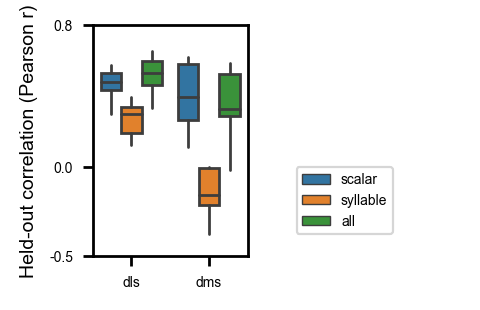

In [50]:
fig, ax = plt.subplots(1, figsize=(1, 1.5))

sns.boxplot(
    **kwargs,
    showfliers=False,
    showcaps=False,
)


ax.legend().remove()
l = fig.legend()
l.set_bbox_to_anchor((2, 0.5))
ax.legend().remove()

clean_ticks(ax, "y", precision=1, zero_symmetry=False)
plt.ylabel("Held-out correlation (Pearson r)")
plt.xlabel("")
plt.show()
savefig(
    fig,
    os.path.join(
        figure_cfg["store_dir"], "dls_vs_dms_encoding_model_average_permouse_boxplot"
    ),
)

In [51]:
types = r_df_ave["type"].unique()
areas = r_df_ave["area"].unique()

In [52]:
dcts = []
for (key1, key2) in itertools.combinations(list(itertools.product(areas, types)), 2):
    if key1[0] == key2[0]:
        continue

    if key1 == key2:
        continue

    if (key1[0] != key2[0]) and (key1[1] != key2[1]):
        continue

    stat, p = use_test(mu_df.xs(key1)["r"], mu_df.xs(key2)["r"])
    dct = {
        "area1": key1[0],
        "type1": key1[1],
        "area2": key2[0],
        "type2": key2[1],
        "p": p,
        "U": stat,
        "f": stat / (len(mu_df.xs(key1)) * len(mu_df.xs(key2))),
        "n1": len(mu_df.xs(key1)),
        "n2": len(mu_df.xs(key2)),
        "comparison_type": use_test.__name__,
    }
    dcts.append(dct)

In [53]:
pval_df = pd.DataFrame(dcts)
pval_df["p"] = multipletests(pval_df["p"], method="holm")[1]

In [54]:
pval_df

,area1,type1,area2,type2,p,U,f,n1,n2,comparison_type
0,dls,scalars,dms,scalars,0.763949,61.0,0.544643,14,8,mannwhitneyu
1,dls,syllables,dms,syllables,0.002552,102.0,0.910714,14,8,mannwhitneyu
2,dls,all,dms,all,0.139650,83.0,0.741071,14,8,mannwhitneyu


In [55]:
import json

In [56]:
with open(
    os.path.join(proc_dirs["dlight"], "dls_vs_dms_encoding_model_average_variant.toml"), "w"
) as f:
    toml.dump(json.loads(pval_df.T.to_json()), f)

# Comparison of transition-aligned averages

In [57]:
observed_zs_dms = pd.read_parquet(
    os.path.join(proc_dirs["dlight"], f"snippet_max_bin_ave_zscored_dms_renorm-True.parquet")
)
observed_zs_dms["area"] = "dms"
observed_zs_dls = pd.read_parquet(
    os.path.join(proc_dirs["dlight"], f"snippet_max_bin_ave_zscored_dls_renorm-True.parquet")
)
observed_zs_dls["area"] = "dls"

observed_zs = pd.concat([observed_zs_dms, observed_zs_dls])
observed_zs = (
    observed_zs.groupby(["x", "init_type", "mouse_id", "area"])["signal_reref_dff_z_hp"]
    .mean()
    .dropna()
)

In [58]:
plt_zs = observed_zs.groupby(["x", "init_type", "area"]).mean()

In [59]:
alpha = 0.68
cutoffs = [
    (1 - alpha) / 2,
    1 - (1 - alpha) / 2,
]

In [60]:
plt_cis = observed_zs.groupby(["x", "init_type", "area"]).quantile(cutoffs)
plt_cis.index = plt_cis.index.set_names("ci", level=-1)

In [61]:
colors = {}
colors[("dls", "syllables_offline")] = sns.color_palette()[0]
colors[("dms", "syllables_offline")] = sns.color_palette()[1]
colors[("dms", "movement")] = sns.color_palette()[2]

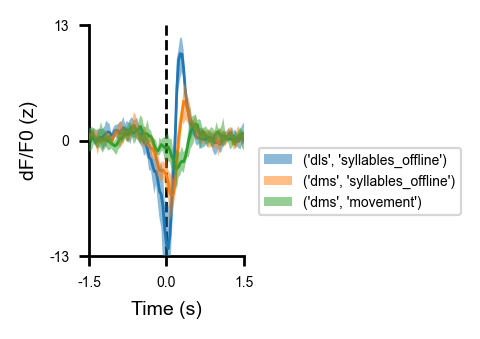

In [62]:
fig, ax = plt.subplots(1, figsize=(1, 1.5))

for _type, _color in colors.items():
    obs_lo = plt_cis.xs(_type, level=("area", "init_type")).iloc[::2]
    obs_hi = plt_cis.xs(_type, level=("area", "init_type")).iloc[1::2]
    plt_xvec = obs_lo.index.get_level_values("x") / 30.0
    ax.fill_between(
        plt_xvec,
        obs_lo.values,
        obs_hi.values,
        fc=_color,
        alpha=0.5,
        zorder=100,
        lw=0,
        ec="none",
        label=_type,
    )
    ax.plot(
        plt_xvec,
        plt_zs.xs(_type, level=("area", "init_type")).values,
        color=_color,
        lw=1,
    )

    ax.set_xlim(-1.5, 1.5)
    ax.set_ylim(-13, 13)

clean_ticks(ax, "y", include_zero=True, zero_symmetry=True, precision=0, dtype=int)
clean_ticks(ax, "x", precision=1, dtype=float)
ax.axvline(x=0, color=plt.rcParams["axes.edgecolor"], zorder=-150, alpha=1, ls="--")
xlims = ax.get_xlim()
plt.ylabel("dF/F0 (z)")
plt.xlabel("Time (s)")
plt.legend(bbox_to_anchor=(1.05, 0.5))
sns.despine()
plt.show()
savefig(
    fig,
    os.path.join(
        figure_cfg["store_dir"],
        f"dls_vs_dms_dlight_initiation_grand_average_quartiles_merged",
    ),
    bbox_inches="tight",
)
# _ax.axvline(x=0, color="k", zorder=-100, alpha=0.5)

In [63]:
peaks = (
    observed_zs.loc[-5:15]
    .groupby(["area", "mouse_id", "init_type"])
    .apply(lambda x: x.values[np.argmax((x.values))])
    .dropna()
)

In [64]:
setup_plotting_env()

In [65]:
peaks

area  mouse_id           init_type        
dls   dlight-chrimson-1  movement              8.413861
                         syllables_offline    14.982803
      dlight-chrimson-2  movement              7.345725
                         syllables_offline    11.477660
      dlight-chrimson-3  movement             10.256664
                         syllables_offline    17.461666
      dlight-chrimson-4  movement              2.573258
                         syllables_offline     8.154692
      dlight-chrimson-5  movement              8.572942
                         syllables_offline    11.140194
      dlight-chrimson-6  movement              9.515573
                         syllables_offline    11.525248
      dlight-chrimson-8  movement              5.673474
                         syllables_offline     9.673658
      dlight-chrimson-9  movement              4.760805
                         syllables_offline     6.205837
      dls-dlight-1       movement              7.096793
     

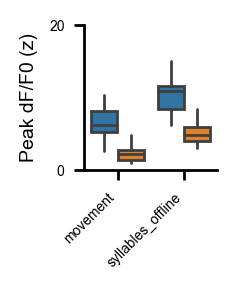

In [66]:
g = sns.catplot(
    data=peaks.reset_index(),
    x="init_type",
    y="signal_reref_dff_z_hp",
    dodge=True,
    height=1.25,
    aspect=1,
    hue="area",
    showfliers=False,
    showcaps=False,
    legend=False,
    kind="box",
)
clean_ticks(g.axes.flat[0], "y", precision=-1, dtype=int)
plt.xticks(rotation=45, ha="right")
plt.xlabel("")
plt.ylabel("Peak dF/F0 (z)")
savefig(
    g.fig,
    os.path.join(
        figure_cfg["store_dir"], "dls_v_dms_transition-aligned_peak_comparison"
    ),
)

In [67]:
use_test = mannwhitneyu

In [68]:
pvals = (
    peaks.groupby("init_type")
    .apply(lambda x: use_test(x.loc["dls"], x.loc["dms"]))
    .apply(pd.Series)
    .rename(columns={0: "U", 1: "p"})
)

In [69]:
pvals["test"] = use_test.__name__
pvals["comparison"] = "Per mouse df/f0 at max location"
pvals["n definition"] = "Per mouse df/f0 at max in waveform"

In [70]:
sz = peaks.groupby(["init_type", "area"]).size().unstack()
sz.columns = [f"n({_})" for _ in sz.columns]

In [71]:
pvals = pvals.join(sz)
pvals["f"] = pvals["U"] / (pvals["n(dls)"] * pvals["n(dms)"])

In [72]:
pvals

,U,p,test,comparison,n definition,n(dls),n(dms),f
init_type,,,,,,,,
movement,108.0,0.000075,mannwhitneyu,Per mouse df/f0 at max location,Per mouse df/f0 at max in waveform,14,8,0.964286
syllables_offline,107.0,0.000119,mannwhitneyu,Per mouse df/f0 at max location,Per mouse df/f0 at max in waveform,14,8,0.955357


In [73]:
with open(
    os.path.join(proc_dirs["dlight"], "dls_v_dms_peak_comparison.toml"), "w"
) as f:
    toml.dump(json.loads(pvals.T.to_json()), f)

In [74]:
pvals

,U,p,test,comparison,n definition,n(dls),n(dms),f
init_type,,,,,,,,
movement,108.0,0.000075,mannwhitneyu,Per mouse df/f0 at max location,Per mouse df/f0 at max in waveform,14,8,0.964286
syllables_offline,107.0,0.000119,mannwhitneyu,Per mouse df/f0 at max location,Per mouse df/f0 at max in waveform,14,8,0.955357
